In [3]:
# Installations
%pip install polars missingno

  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# Imports
import sqlite3
import pandas as pd
import polars as pl
import missingno as msno
import matplotlib.pyplot as mplt
import seaborn as sb
sb.set_theme()
import plotly.express as px
import numpy as np
from typing import (
    Union,
    Any,
    List,
    Tuple,
)
import math
import scipy.stats as ss
from numpy.typing import NDArray
from pandas import DataFrame, Series
from collections import Counter

Number = Union[int, float]
OneDimArray = Union[List[Number], NDArray, Series]
TwoDimArray = Union[NDArray, DataFrame]

In [2]:
# Functions

def extract_data_to_polars(db_path: str, query: str) -> pl.DataFrame:
    """
    Extracts data from a SQLite database into a Polars DataFrame.

    Parameters:
    - db_path (str): The path to the SQLite database file.
    - query (str): The SQL query to execute for extracting data.

    Returns:
    - pl.DataFrame: A Polars DataFrame containing the extracted data.
    """
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        column_names = [description[0] for description in cursor.description]
        rows = cursor.fetchall()
        df = pl.DataFrame(rows, schema=column_names)
    return df

def normalize_z(dfin: pl.DataFrame, columns_means: list = None, columns_stds: list = None) -> tuple:
    """
    Normalize the DataFrame columns using Z-score normalization.

    Parameters:
    - dfin (pd.DataFrame): The input DataFrame.
    - columns_means (list, optional): Means of the columns used for normalization. Defaults to None.
    - columns_stds (list, optional): Standard deviations of the columns used for normalization. Defaults to None.

    Returns:
    - tuple: A tuple containing:
        - pl.DataFrame: The normalized DataFrame.
        - list: Means of the columns used for normalization.
        - list: Standard deviations of the columns used for normalization.
    """
    if columns_means is None: columns_means = dfin.mean()
    if columns_stds is None: columns_stds = dfin.std()
    dfout = pl.DataFrame(((np.array(dfin.clone()) - np.array(columns_means)) / np.array(columns_stds)), schema=dfin.columns)
    return dfout, columns_means, columns_stds

def correlation_ratio(categories: Union[List[str], np.ndarray], numerical: Union[List[float], np.ndarray]) -> float:
    """
    Calculates the correlation ratio between categorical and numerical variables.

    Parameters:
    - categories (Union[List[str], np.ndarray]): List or array of categorical variable values.
    - numerical (Union[List[float], np.ndarray]): List or array of numerical variable values.

    Returns:
    - float: The correlation ratio between the categorical and numerical variables.
    """
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = numerical[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(numerical,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def remove_incomplete_samples(
    x: Union[List[Any], OneDimArray], y: Union[List[Any], OneDimArray]
) -> Tuple[Union[List[Any], OneDimArray], Union[List[Any], OneDimArray]]:
    x = [v if v is not None else np.nan for v in x]
    y = [v if v is not None else np.nan for v in y]
    arr = np.array([x, y]).transpose()
    arr = arr[~np.isnan(arr).any(axis=1)].transpose()
    if isinstance(x, list):
        return arr[0].tolist(), arr[1].tolist()
    else:
        return arr[0], arr[1]


def replace_nan_with_value(
    x: Union[List[Any], OneDimArray],
    y: Union[List[Any], OneDimArray],
    value: Any,
) -> Tuple[NDArray, NDArray]:
    x = np.array(
        [v if v == v and v is not None else value for v in x]
    ) 
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y

def conditional_entropy(
    x: Union[OneDimArray, List[str]],
    y: Union[OneDimArray, List[str]],
    nan_strategy: str = "replace",
    nan_replace_value: Any = 0.0,
    log_base: Number = math.e,
) -> float:
    """
    Calculates the conditional entropy of x given y: S(x|y)

    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy

    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    log_base: float, default = e
        specifying base for calculating entropy. Default is base e.

    Returns:
    --------
    float
    """
    if nan_strategy == "replace":
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == "drop":
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

def theils_u(x: Union[List[Any], np.ndarray], y: Union[List[Any], np.ndarray]) -> float:
    """
    Calculates Theil's U coefficient, a measure of association between two categorical variables.

    Parameters:
    - x (Union[List[Any], np.ndarray]): List or array of values for the first categorical variable.
    - y (Union[List[Any], np.ndarray]): List or array of values for the second categorical variable.

    Returns:
    - float: The Theil's U coefficient.
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [3]:
# Initialization
db_path = 'src/data/calls.db'  
query = 'SELECT * FROM calls'  
df = extract_data_to_polars(db_path, query)

In [4]:
print(f"Columns:\n{df.columns}\n")
print(f"Shape:\n{df.shape}\n")

df.head()

Columns:
['ID', 'Call Duration', 'Call Frequency', 'Financial Loss', 'Flagged by Carrier', 'Is International', 'Previous Contact Count', 'Country Prefix', 'Call Type', 'Timestamp', 'Device Battery', 'Scam Call']

Shape:
(12000, 12)



ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
i64,i64,i64,f64,str,str,i64,str,str,str,str,str
947429,-719,12,42.13,"""Suspicious""","""Yes""",1,"""95""","""Voip""","""2023-07-23 09:…","""Fully Charged""","""Scam"""
540498,116,3,29.9,"""Unlikely""","""Yes""",0,"""91""","""Mobile""","""2023-09-05 20:…","""Fully Charged""","""Scam"""
434243,29,16,723.46,"""Very Suspiciou…","""Yes""",2,"""91""","""Voip""","""2023-12-16 11:…","""Charging""","""Scam"""
903537,-563,4,64.287478,"""Unlikely""","""Yes""",3,"""91""","""Telegram""","""2023-02-25 10:…","""Fully Charged""","""Not Scam"""
969179,312,19,0.0,"""Unlikely""","""Yes""",0,"""91""","""Telegram""","""2023-11-10 15:…","""Fully Charged""","""Scam"""


The data contains 12000 data points, 12 columns with the following classifications:

- **Categorical columns**: Flagged by Carrier, Is International, Previous Contact Count, Country Prefix, Call Type, Device Battery, Scam Call
- **Numerical columns**: ID, Call Duration, Call Frequency, Financial Loss
- **Datetime column**: Timestamp

Thus, the columns are recast into their appropriate types for optimized memory usage and better readability.

In [5]:
df = df.with_columns(pl.col(["Flagged by Carrier", "Is International", "Previous Contact Count", "Country Prefix", "Call Type", "Device Battery", "Scam Call" ]).cast(pl.String).cast(pl.Categorical))
df.head()

ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
i64,i64,i64,f64,cat,cat,cat,cat,cat,str,cat,cat
947429,-719,12,42.13,"""Suspicious""","""Yes""","""1""","""95""","""Voip""","""2023-07-23 09:…","""Fully Charged""","""Scam"""
540498,116,3,29.9,"""Unlikely""","""Yes""","""0""","""91""","""Mobile""","""2023-09-05 20:…","""Fully Charged""","""Scam"""
434243,29,16,723.46,"""Very Suspiciou…","""Yes""","""2""","""91""","""Voip""","""2023-12-16 11:…","""Charging""","""Scam"""
903537,-563,4,64.287478,"""Unlikely""","""Yes""","""3""","""91""","""Telegram""","""2023-02-25 10:…","""Fully Charged""","""Not Scam"""
969179,312,19,0.0,"""Unlikely""","""Yes""","""0""","""91""","""Telegram""","""2023-11-10 15:…","""Fully Charged""","""Scam"""


It seems quite strange that "Call Duration" and "Financial Loss" can be negative - there might be errors in data entry.

However, it is possible that Financial Loss can be negative, meaning that there was actually Financial Gain, due to techniques like reverse-scamming, etc. This should be taken into consideration. However, it is not possible to know this without more context but considering the understanding of the term "Financial Loss", it could be likely that the data input inserted the - sign to indicate a loss.

It is impossible for time to be negative.

Therefore, Financial Loss and Call Duration must be corrected to be absolute (magnitude only)

In [6]:
df = df.with_columns(pl.col('Call Duration').abs().alias('Call Duration'))
df = df.with_columns(pl.col('Financial Loss').abs().alias('Financial Loss'))
df.head()

ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
i64,i64,i64,f64,cat,cat,cat,cat,cat,str,cat,cat
947429,719,12,42.13,"""Suspicious""","""Yes""","""1""","""95""","""Voip""","""2023-07-23 09:…","""Fully Charged""","""Scam"""
540498,116,3,29.9,"""Unlikely""","""Yes""","""0""","""91""","""Mobile""","""2023-09-05 20:…","""Fully Charged""","""Scam"""
434243,29,16,723.46,"""Very Suspiciou…","""Yes""","""2""","""91""","""Voip""","""2023-12-16 11:…","""Charging""","""Scam"""
903537,563,4,64.287478,"""Unlikely""","""Yes""","""3""","""91""","""Telegram""","""2023-02-25 10:…","""Fully Charged""","""Not Scam"""
969179,312,19,0.0,"""Unlikely""","""Yes""","""0""","""91""","""Telegram""","""2023-11-10 15:…","""Fully Charged""","""Scam"""


In [7]:
print(f"Any duplicated values: {df.is_duplicated().any()}\n")

duplicated_df = df.filter(df.is_duplicated()).sort(by=["ID"])
print(f"Duplicated values:\n{duplicated_df.head()}")
print(f"No. of unique values within duplications: {duplicated_df.unique().shape[0]}")
print(f"No. of unqiue values: {df.unique().shape[0]}")

df = df.unique(keep="first")

Any duplicated values: True

Duplicated values:
shape: (5, 12)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ID     ┆ Call       ┆ Call       ┆ Financial ┆ … ┆ Call Type ┆ Timestamp ┆ Device    ┆ Scam Call │
│ ---    ┆ Duration   ┆ Frequency  ┆ Loss      ┆   ┆ ---       ┆ ---       ┆ Battery   ┆ ---       │
│ i64    ┆ ---        ┆ ---        ┆ ---       ┆   ┆ cat       ┆ str       ┆ ---       ┆ cat       │
│        ┆ i64        ┆ i64        ┆ f64       ┆   ┆           ┆           ┆ cat       ┆           │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 101266 ┆ 120        ┆ 19         ┆ 36.881029 ┆ … ┆ Telegram  ┆ 2023-07-2 ┆ Not       ┆ Not Scam  │
│        ┆            ┆            ┆           ┆   ┆           ┆ 4         ┆ Charging  ┆           │
│        ┆            ┆            ┆           ┆   ┆           ┆ 21:53:00  ┆           ┆           │
│ 101266 ┆ 120        ┆ 19  

Duplicate values are checked to ensure there are no repetitions, which could affect model training later by introducing bias, leading to overfitting where the model performs well on training data but poorly on new data. They can also inflate performance metrics, giving a false sense of model effectiveness, and skew feature importance. Moreover, duplicates increase training time without adding any new information

Out of 10,000 unique values, there are 2,500 duplicate values corresponding to only 500 IDs

Therefore, duplicate values are removed to maintain unique entries and ensure better model performance.

Missingness:
Axes(0.125,0.11;0.698618x0.77)



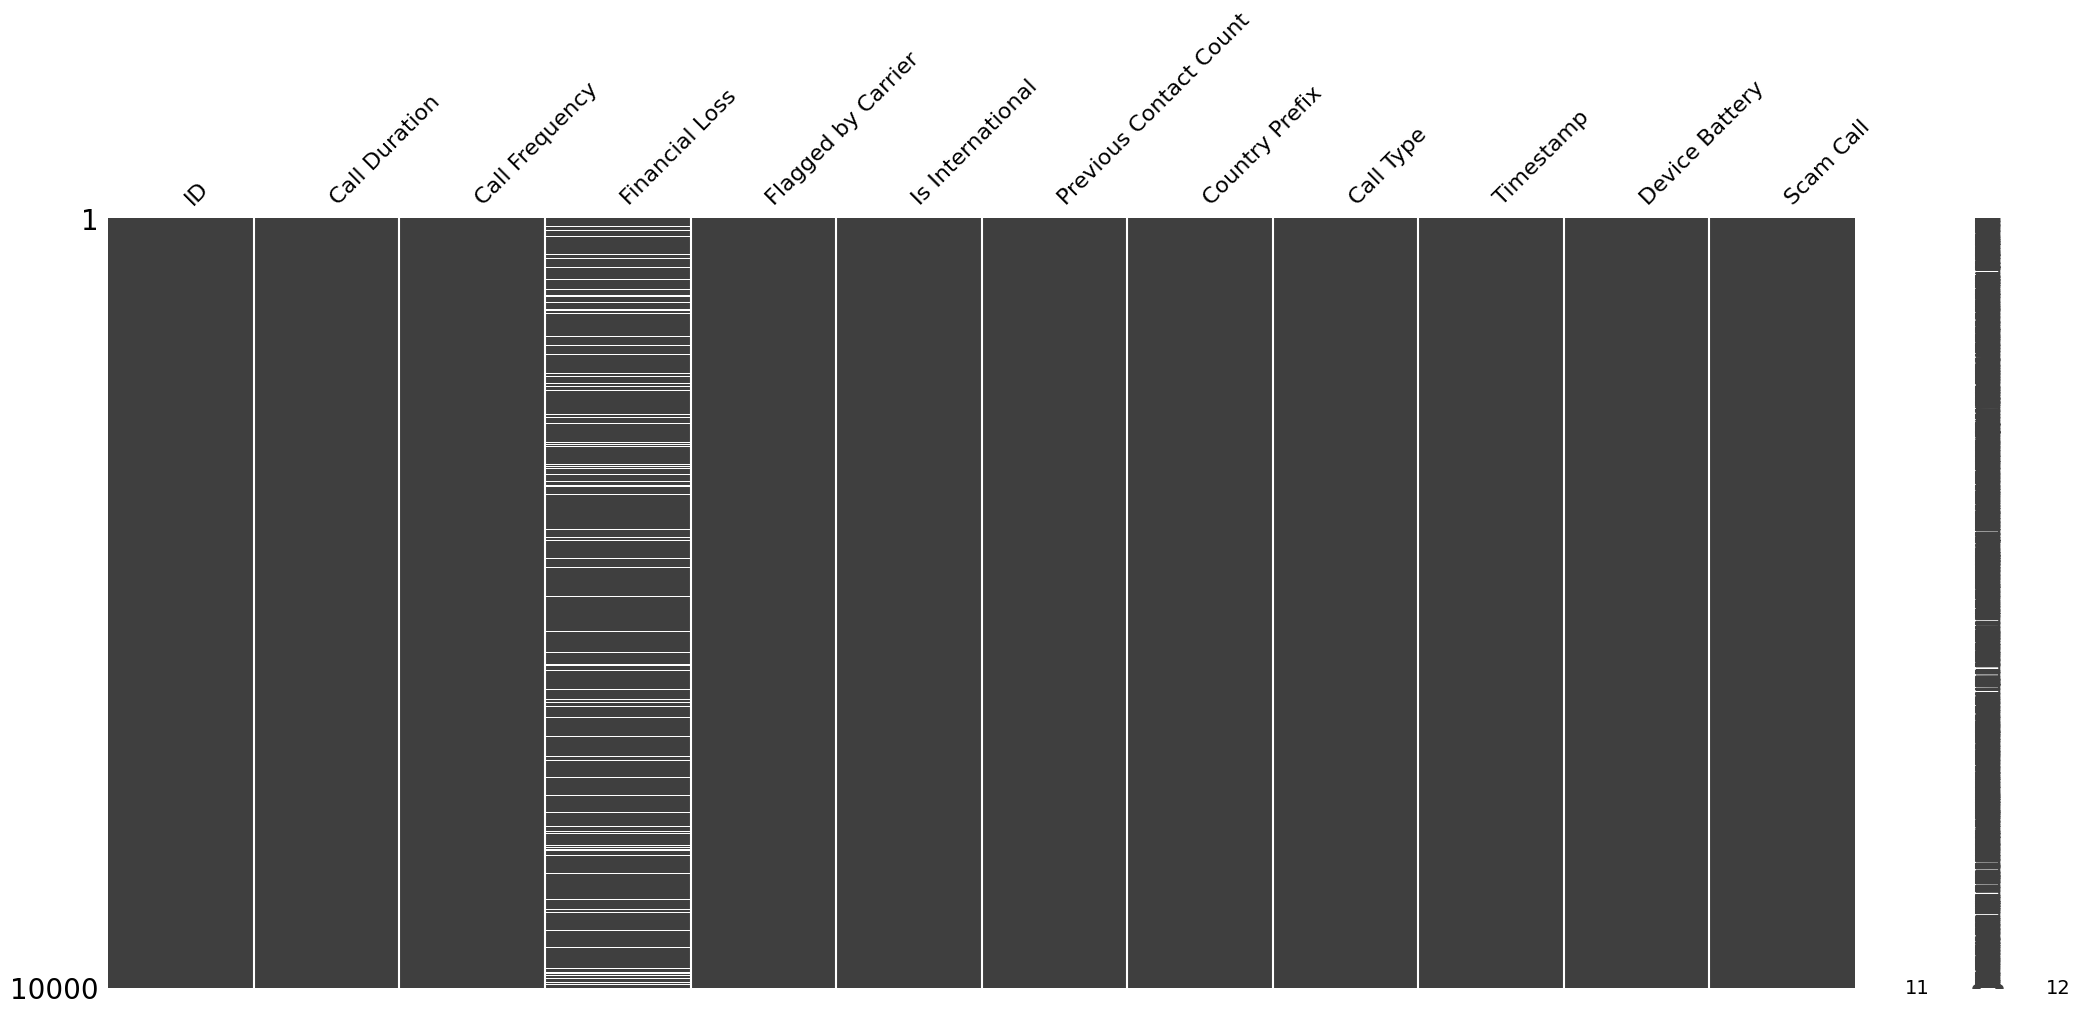

In [8]:
print(f"Missingness:\n{msno.matrix(df.to_pandas())}\n")

In [9]:
print(f"Number of missing values in 'Financial Loss': {df.filter(df['Financial Loss'].is_null()).shape[0]}")

Number of missing values in 'Financial Loss': 1135


**Evaluation**

The missingness visualization presents a case of Missing Completely at Random, where some data in the "Financial Loss" column are missing, regardless of the other columns like "Call Duration", "Call Frequency", "Flagged by Carrier", "Country Prefix" or "Call Type".

However, as all 10000 values for the other columns present no missing values, the dataset is considered relatively comprehensive.

1135 values are missing for 'Financial Loss' column, but the data in the other columns are present and could be  valuable, especially considering there are only 10000 unique data points. Removing these missing values would mean further reducing the dataset size (~10%!) which could lead to reduced statistical power, making it more challenging to detect meaningful patterns or relationships between variables, impacting model performance.

Data is valuable especially in small sizes!

In [10]:
df = df.with_columns(pl.col('Call Type').map_elements(lambda x: 'WhatsApp' if x == 'Whats App' else x, return_dtype = pl.String).alias('Call Type'))

cat_df = df.select([col for col, dtype in zip(df.columns, df.dtypes) if dtype not in [pl.Float32, pl.Float64, pl.Int32, pl.Int64] and col != "Timestamp"])

for col in cat_df.columns:
        freq_count_df = cat_df[col].value_counts().sort(by=["count"], descending=True)
        fig = px.bar(x=freq_count_df[col], y=freq_count_df["count"], title=f'"{col}" Frequency', labels={"x": col, 'y': 'Frequency'})
        fig.show()

Carriers do not seem to do a good job of flagging Scam calls, as there are 1346 confirmed "Scam Calls" that were "unlikely" to be scam calls.

Most calls are international (from India due to +91 country prefix), and previously had no contact with the individual. WhatsApp is also the most used platform for the call.

This analysis consisted of both Scam and Not Scam calls, but we can filter to simply Scam calls to get a better sense of the features that indicate a Scam for the model training.

In [11]:
cat_df_scam = cat_df.filter(pl.col("Scam Call") == "Scam")

for col in cat_df_scam.columns:
        freq_count_df = cat_df_scam[col].value_counts().sort(by=["count"], descending=True)
        fig = px.bar(x=freq_count_df[col], y=freq_count_df["count"], title=f'"{col}" Frequency', labels={"x": col, 'y': 'Frequency'})
        fig.show()

In fact, all of the above observations pertain to Scam Calls. Additionally, Device Battery seems to be highly irrelevant as its frequency distribution is relatively uniform across the dataset

In [15]:
numeric_df = df.select([col for col, dtype in zip(df.columns, df.dtypes) if dtype in [pl.Float32, pl.Float64, pl.Int32, pl.Int64]])
numeric_df.describe()

statistic,ID,Call Duration,Call Frequency,Financial Loss
str,f64,f64,f64,f64
"""count""",10000.0,10000.0,10000.0,8865.0
"""null_count""",0.0,0.0,0.0,1135.0
"""mean""",549171.6046,218.6169,10.6538,108.32344
"""std""",258983.069885,213.780471,5.841212,189.030987
"""min""",100017.0,19.0,2.0,0.0
"""25%""",328258.0,42.0,6.0,0.0
"""50%""",542309.0,120.0,9.0,19.300388
"""75%""",777873.0,318.0,15.0,89.572319
"""max""",999709.0,822.0,27.0,1055.44


A basic overview of the numeric data signifies the mean, median, and ranges (min & max) of the calls.

To better illustrate the distributions, the following visualization is conducted after z-normalization. 

Z-normalization is necessary as the numeric columns all have different ranges. By normalizing the variables, I ensure that all predictors contribute to the model on a comparable scale. This is particularly important when the predictor variables have different units or magnitudes, as it prevents certain variables from dominating certain model equation solely due to their scale. For instance, Call Duration is like to be in minutes and has a huge variance, while Call Frequency does not even exceed 30.

statistic,ID,Call Duration,Call Frequency,Financial Loss
str,f64,f64,f64,f64
"""count""",10000.0,10000.0,10000.0,10000.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",1.7373e-16,1.1084e-16,-4.2633e-18,NaN
"""std""",1.0,1.0,1.0,NaN
"""min""",-1.734301,-0.933747,-1.481508,-0.573046
"""25%""",-0.853004,-0.82616,-0.796718,-0.573046
"""50%""",-0.026498,-0.4613,-0.283126,-0.381649
"""75%""",0.883075,0.464884,0.744058,0.978075
"""max""",1.73964,2.822443,2.798426,5.010377


Text(0.5, 1.0, 'Distribution of all numeric features (ID, Call Duration, Call Frequency, Financial Loss)')

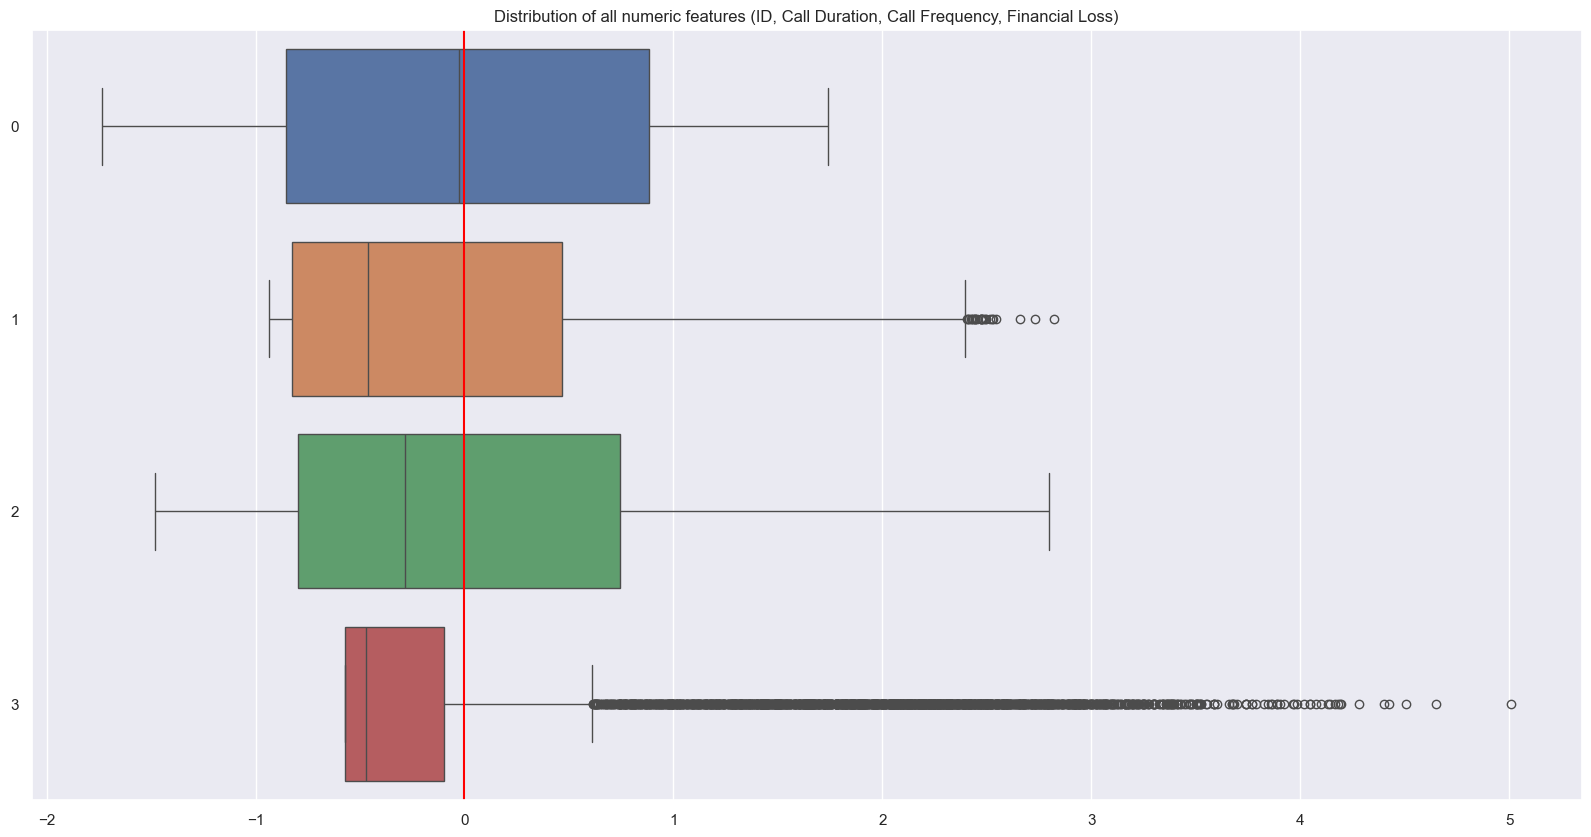

In [16]:
display(normalize_z(numeric_df)[0].describe())

mplt.figure(figsize=(20,10))
sb.boxplot(normalize_z(numeric_df)[0], orient="h")
mplt.axvline(x=0, color="red")
mplt.title("Distribution of all numeric features (ID, Call Duration, Call Frequency, Financial Loss)")

The boxplot effectively illustrates the distribution, revealing the following insights:

Overall, the data tends to be more spread out towards the right side, indicating a longer right tail compared to the left. The median is negative, implying that Call Durations and Call Frequency are predominantly shorter than the median value.
The ID feature appears to be inconsequential, evidenced by its uniform distribution and a median close to zero, as anticipated.
Financial Losses exhibit numerous outliers, primarily skewed towards larger losses. However, the 75th percentile is lower than the mean, suggesting that the significant losses heavily outweigh the minor losses.

<hr>
As previously mentioned, there are 1135 missing values for the "Financial Loss" column. Simply removing these data points is a poor decision. However, a better decision will be to impute these missing values with the mean, as it is evident that it will not affect the z-normalized distribution (see the boxplot above). Therefore these valuable data points will be preserved and useful.

In [17]:
df_imputed = df.with_columns(
    pl.col('Financial Loss').fill_null(df['Financial Loss'].mean()).alias('Financial Loss')
)
print(f"Number of missing values in 'Financial Loss': {df_imputed.filter(df_imputed['Financial Loss'].is_null()).shape[0]}")

df_imputed.head()

Number of missing values in 'Financial Loss': 0


ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
i64,i64,i64,f64,cat,cat,cat,cat,str,str,cat,cat
658580,27,7,0.0,"""Unlikely""","""Yes""","""2""","""65""","""WhatsApp""","""2023-11-29 03:…","""Charging""","""Not Scam"""
154348,47,7,681.63,"""Very Suspiciou…","""Yes""","""2""","""91""","""Voip""","""2024-03-23 22:…","""Fully Charged""","""Scam"""
670762,28,6,0.0,"""Unlikely""","""Yes""","""2""","""44""","""Voip""","""2024-01-12 11:…","""Fully Charged""","""Scam"""
941326,123,19,141.48,"""Unlikely""","""Yes""","""0""","""95""","""Landline""","""2023-01-11 13:…","""Charging""","""Scam"""
542480,300,7,108.32344,"""Unlikely""","""Yes""","""0""","""1""","""Landline""","""2023-12-08 07:…","""Fully Charged""","""Not Scam"""


Correlation Ratio (often denoted as eta) is used to quantify the relationship between a categorical group and continuous variables. It is calculated by comparing the variance of the means of each variable to the overall variance of the entire dataset. This ratio provides insight into how effectively a continuous value can predict its associated category.

The output of the Correlation Ratio falls within the range of [0, 1], where:

0 indicates no relationship between the continuous variable and the categories.
1 suggests a perfect correlation, implying that the continuous variable perfectly predicts the categories.

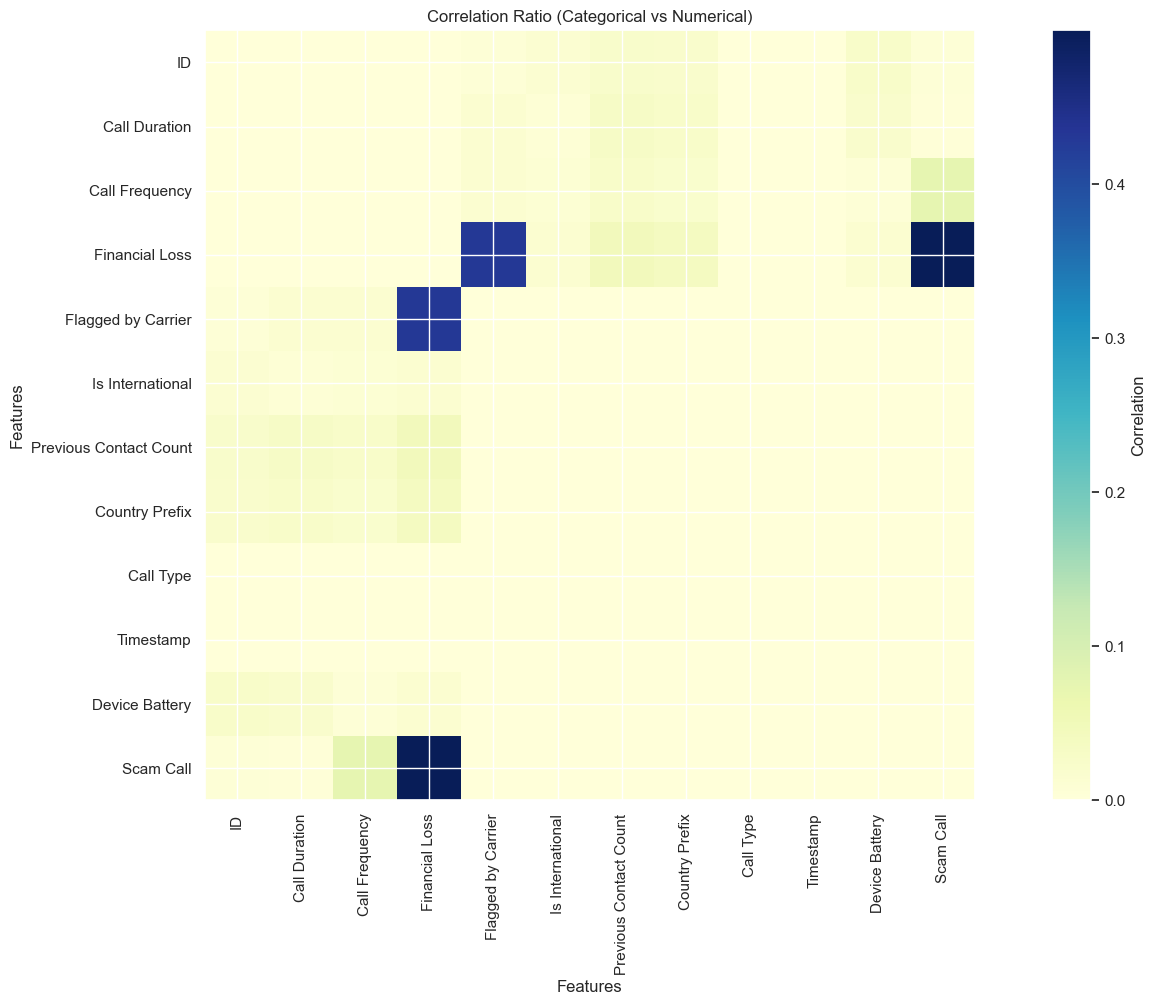

In [18]:
num_cols = len(df_imputed.columns)
correlation_matrix = np.zeros((num_cols, num_cols))

for i in range(num_cols):
    for j in range(num_cols):
        if i != j:
            if df_imputed[df_imputed.columns[i]].dtype in [pl.Int64, pl.Float64] and df_imputed[df_imputed.columns[j]].dtype == pl.Categorical:
                correlation_matrix[i, j] = correlation_ratio(df_imputed[df_imputed.columns[j]].to_numpy(), df_imputed[df_imputed.columns[i]].to_numpy())
            elif df_imputed[df_imputed.columns[j]].dtype in [pl.Int64, pl.Float64] and df_imputed[df_imputed.columns[i]].dtype == pl.Categorical:
                correlation_matrix[i, j] = correlation_ratio(df_imputed[df_imputed.columns[i]].to_numpy(), df_imputed[df_imputed.columns[j]].to_numpy())

mplt.figure(figsize=(20, 10))
mplt.imshow(correlation_matrix, cmap='YlGnBu')
mplt.colorbar(label='Correlation')
mplt.title('Correlation Ratio (Categorical vs Numerical)')
mplt.xticks(ticks=np.arange(len(correlation_matrix)), labels=df_imputed.columns, rotation=90)
mplt.yticks(ticks=np.arange(len(correlation_matrix)), labels=df_imputed.columns)
mplt.xlabel('Features')
mplt.ylabel('Features')
mplt.show()

The correlation matrix explicitly indicates that "Financial Loss" is a very strong indicator of a "Scam Call", as they are highly correlated. This is followed by "Call Frequency"

Being "Flagged by Carrier" is also relatively highly correlated with "Financial Loss".

The other features have very weak correlations.

<hr>

Theil's U is a measure based on the conditional entropy between two variables, x and y. In simple terms, it assesses how many possible states y can have given the value of x, and how often these states occur. This measure is derived from a nominal variation of Pearson’s Chi-Square Test and offers several advantages: Like correlation, its output ranges from 0 to 1, where 0 indicates no association and 1 indicates full association. Unlike correlation, Theil's U does not have negative values; the association is either present or absent. Theil's U is asymmetric, meaning 𝑈 ( 𝑥 , 𝑦 ) ≠ 𝑈 ( 𝑦 , 𝑥 ). This is different from Cramer’s V, a symmetric measure, where 𝑉 ( 𝑥 , 𝑦 ) = 𝑉 ( 𝑦 , 𝑥 ). In practical terms, Theil’s U can help determine that knowing y provides information about x, but knowing x does not necessarily provide information about y.

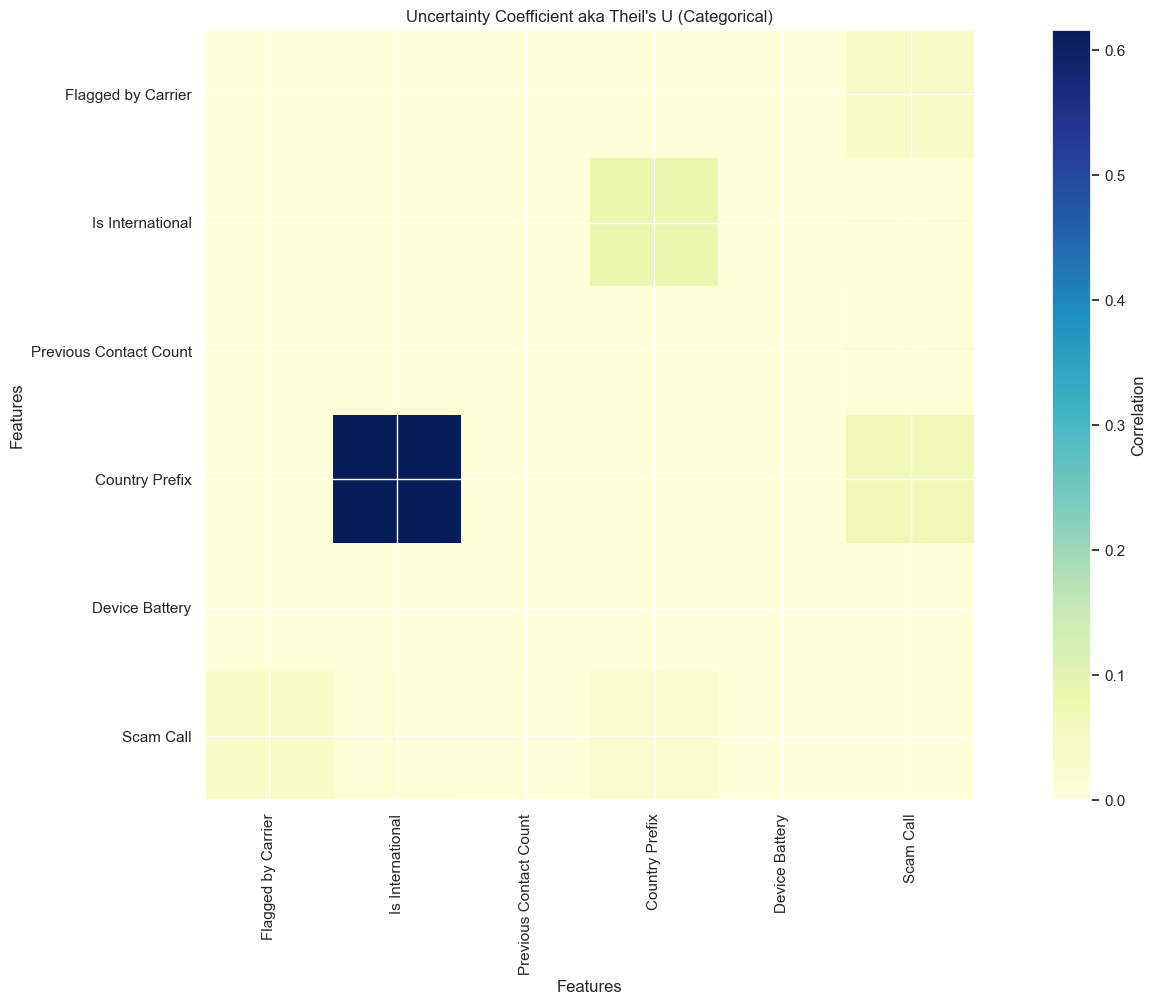

In [19]:
df_imputed_cat = df_imputed.select([col for col, dtype in zip(df_imputed.columns, df_imputed.dtypes) if dtype == pl.Categorical])
num_cols = len(df_imputed_cat.columns)
correlation_matrix = np.zeros((num_cols, num_cols))
for i in range(num_cols):
    for j in range(num_cols):
        if i != j:
            if df_imputed_cat[df_imputed_cat.columns[i]].dtype == pl.Categorical and df_imputed_cat[df_imputed_cat.columns[j]].dtype == pl.Categorical:
                correlation_matrix[i, j] = theils_u(df_imputed_cat[df_imputed_cat.columns[j]].to_numpy(), df_imputed_cat[df_imputed_cat.columns[i]].to_numpy())
            elif df_imputed_cat[df_imputed_cat.columns[j]].dtype == pl.Categorical and df_imputed_cat[df_imputed_cat.columns[i]].dtype == pl.Categorical:
                correlation_matrix[i, j] = theils_u(df_imputed_cat[df_imputed_cat.columns[i]].to_numpy(), df_imputed_cat[df_imputed_cat.columns[j]].to_numpy())

mplt.figure(figsize=(20, 10))
mplt.imshow(correlation_matrix, cmap='YlGnBu')
mplt.colorbar(label='Correlation')
mplt.title('Uncertainty Coefficient aka Theil\'s U (Categorical)')
mplt.xticks(ticks=np.arange(len(correlation_matrix)), labels=df_imputed_cat.columns, rotation=90)
mplt.yticks(ticks=np.arange(len(correlation_matrix)), labels=df_imputed_cat.columns)
mplt.xlabel('Features')
mplt.ylabel('Features')
mplt.show()

The correlation matrix explicitly indicates that "Country Prefix" is very highly correlated with "Is Interational", as expected as the prefix naturally indicates the originating country.

The asymmetry of the matrix indicates a uni-directional relationship, where for instance, the "Country Prefix" is correlated with being a "Scam Call", followed by being "Flagged by Carrier".

However, a "Scam call" much less likely indicates "Flagged by Carrier" and "Country Prefix"

The other features have very weak or no correlations.

Through this step-by-step procedural exploratory data analysis (EDA), it is clear that the model training phase will involve:

- Modifying the data by converting "Call Duration" and "Financial Loss" to their absolute values
- Removing duplicate entries
- Imputing missing values in the "Financial Loss" column by filling them with the mean.
- Focusing on features that are highly correlated with "Scam Call" (such as Financial Loss, Call Frequency, and Country Prefix)
- Removing features that have low or no correlation with "Scam Call" (such as ID, Timestamp, and Device Battery)

Sources

[Python code for Correlation Ratio & Theil's U](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)